In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import math
import scipy
from collections import Counter
import copy
%matplotlib inline

In [2]:
base_time = 1474275600
class BInfo:
    def __init__(self,params):
        self.id = params[4]
        self.num_operators = params[0]
        self.arrival_time = np.array(params[1]) - base_time
        self.start_time = np.array(params[2]) - base_time
        self.end_time = np.array(params[3]) - base_time
    def __str__(self):
        line = 'bank : ' + str(self.id) + '\n'
        line += str(self.num_operators) + '\n'
        line += str(self.arrival_time[0]) + ' '
        line += str(self.start_time[0]) + ' '
        line += str(self.end_time[0])
        return line

In [3]:
def read_from_files(files):
    data = []
    k = 0
    for fpath in files:
        params = []
        with open(fpath) as f_in:
            i = -1
            for line in f_in:
#                 print(line)
                i += 1
                if i == 1:
                    continue
                s = line.split()
                
                if i == 0:
                    params.append(int(s[-1]))
                    for j in range(3):
                        params.append([])
                else :
                    for j in range(3):
                        params[j + 1].append(int(s[j]))
        params.append(k)
        data.append(BInfo(params))            
        k += 1
    return data

In [4]:
files = ['data/office_' + str(i) for i in range(5)]
data = read_from_files(files)

## 1

Первая серия моментов времени образует пуассоновский процесс $N_t = sup\{n: S_n \leq t\}$, так как по условию промежутки времени $\xi_i$ между приходом следующим $i$-м клиентном распределены экспоненциально ($\xi_i \sim exp(\lambda)$) и независимы в совокупности.

In [5]:
def build_first_plot(info):
    n = len(info.arrival_time)
    plt.figure(figsize=(15,7))
    plt.title('bank ' + str(info.id))
    plt.xlabel('time , sec')
    plt.ylabel('ordinal number')
    for i in range(n):
        x1 = [info.arrival_time[i] , info.start_time[i]]
        x2 = [info.start_time[i] , info.end_time[i]]
        plt.plot(x1,[i,i], color = 'r')
        plt.plot(x2,[i,i], color = 'g')
    plt.show()

def build_poiss_proc_plot(info):
    n = len(info.arrival_time)
    plt.figure(figsize=(15,7))
    plt.grid(True)
    plt.title('bank ' + str(info.id))
    plt.xlabel('t , sec')
    plt.ylabel('N_t')
    X = np.zeros(2*(n+1)) # build T
    Y = np.array([i for i in range(0,2*(n+1))]) // 2 #build N_t
    for j in range(2,2*(n+1)):
        X[j] = info.arrival_time[Y[j] - 1]
    plt.plot(X,Y)
    plt.xlim([0,X[-1] + 10])
    plt.ylim([0,Y[-1]+5])
    plt.show()

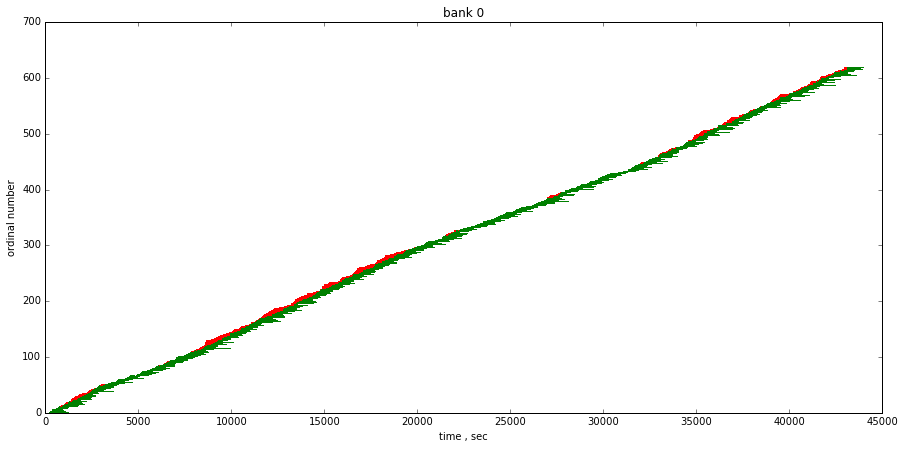

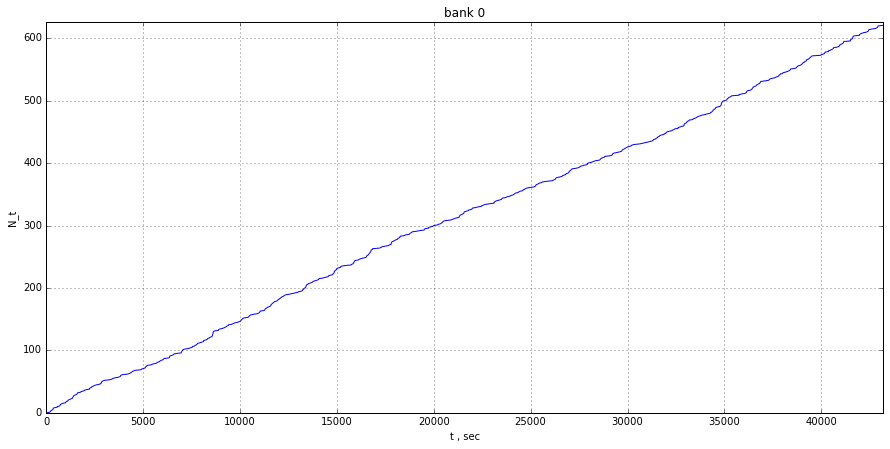

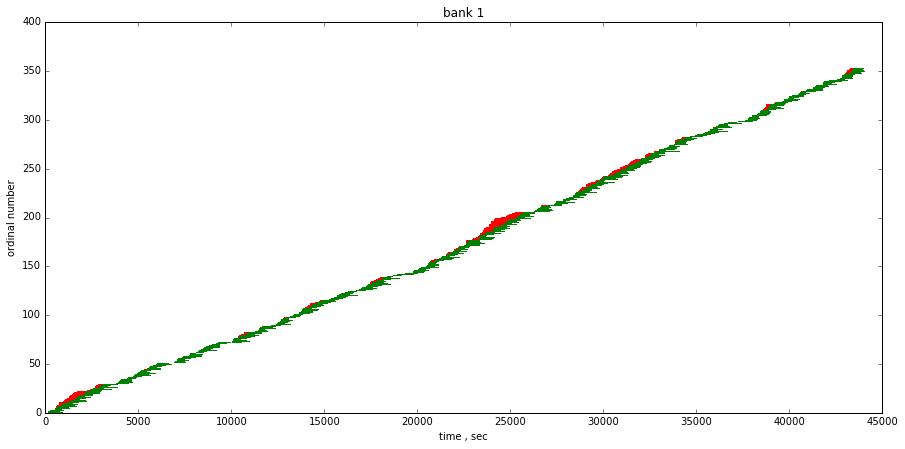

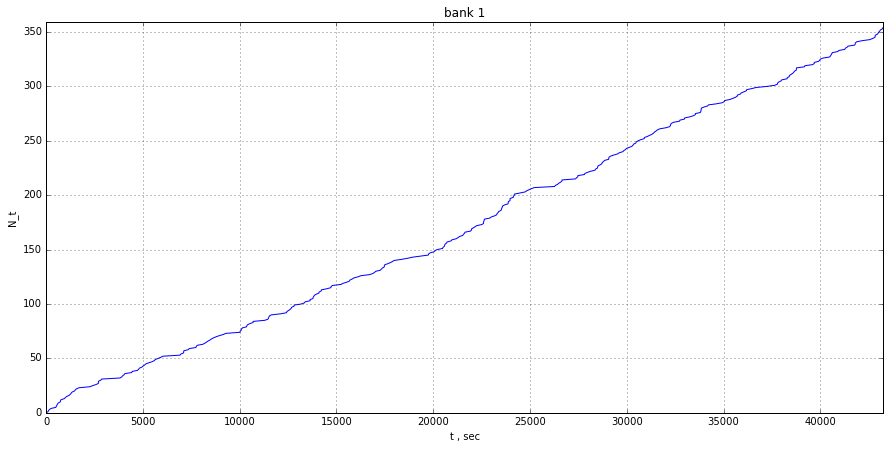

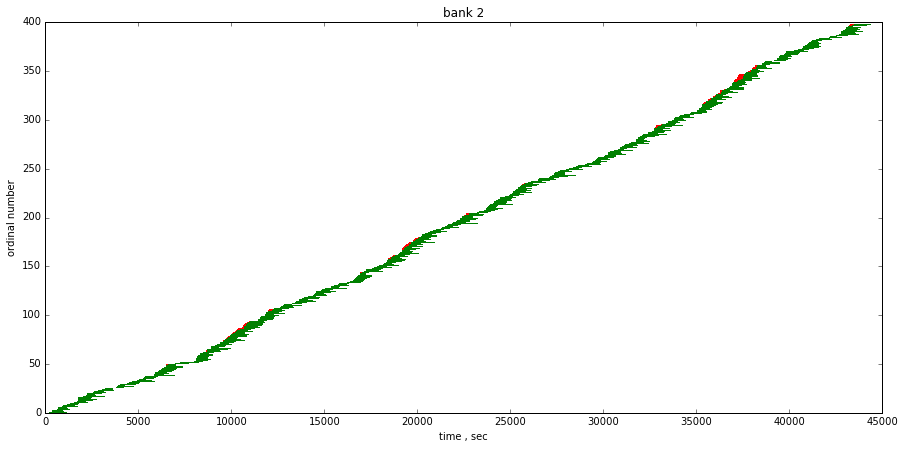

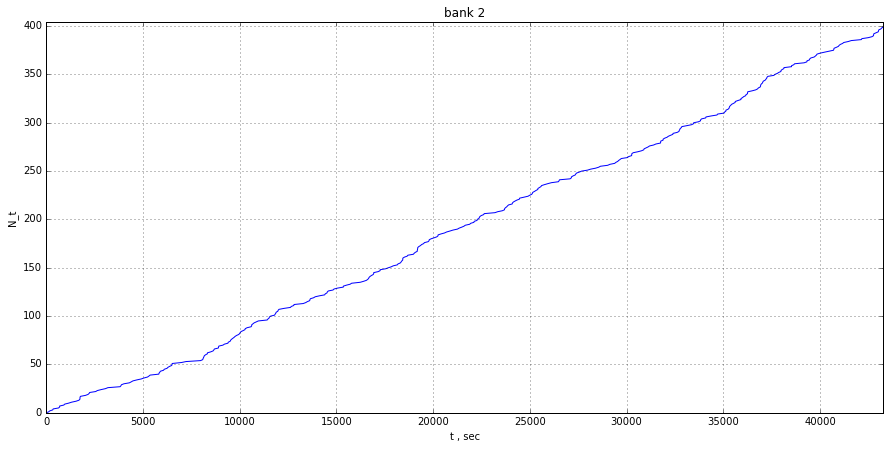

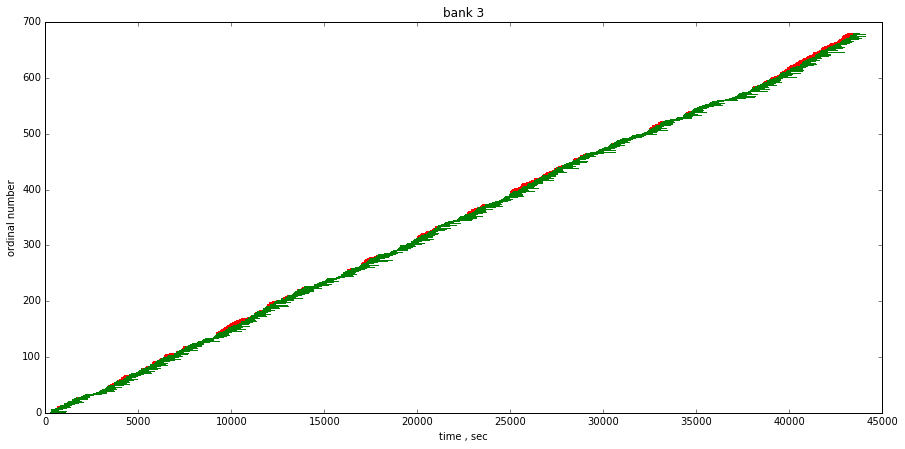

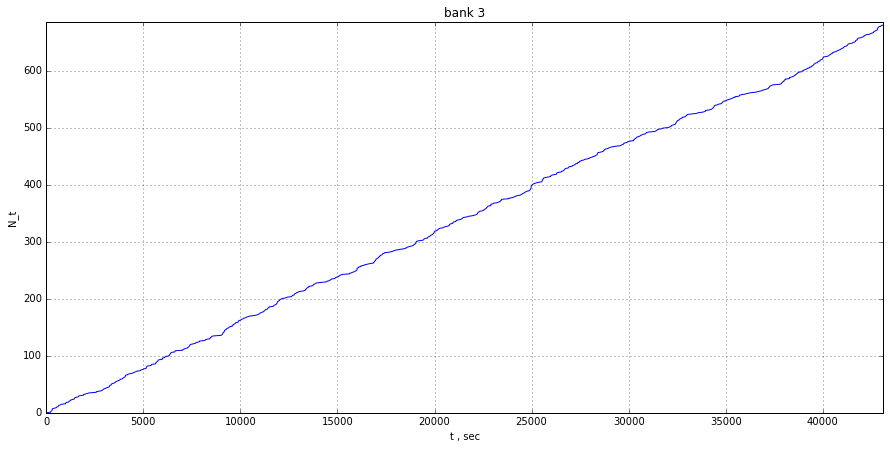

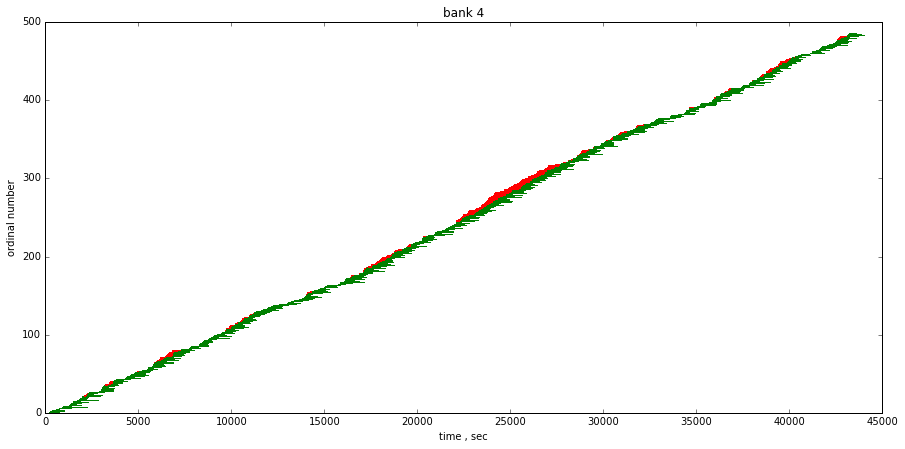

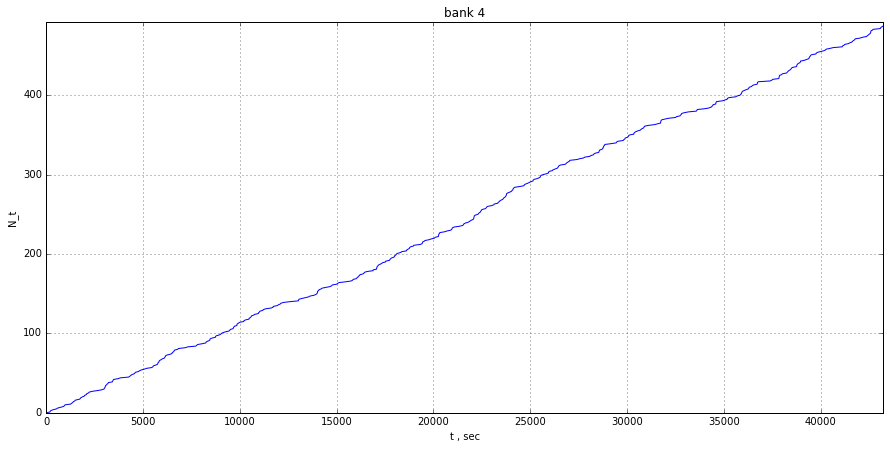

In [6]:
for i in range(5) : 
    build_first_plot(data[i])
    build_poiss_proc_plot(data[i])

Для экспоненциального распределения методом максимального правдоподобия получаем оценку $\hat{\lambda} = \frac{1}{\overline{X}}$, где $X_i = t_i - t_{i-1}$ , $t_i$ - время прихода $i$ - го клиента ($t_0 :=0$)

In [7]:
def get_estimation_exp(info):
    X = np.zeros(len(info.arrival_time))
    for i in range(1,len(info.arrival_time)):
        X[i] = info.arrival_time[i] - info.arrival_time[i-1]
    X[0] = info.arrival_time[0]
    return 1 / np.mean(X)

def get_avg_service_duration(info):
    service_duration = info.end_time - info.start_time
    return np.mean(service_duration)

In [8]:
lmb = []
avg_service_duration = []
for info in data:
    lmb.append(get_estimation_exp(info))
    avg_service_duration.append(get_avg_service_duration(info))
    print(str(info.id) + ': lambda = ' + str(lmb[-1]) +\
          ', avg service duration = ' + str(avg_service_duration[-1]))

0: lambda = 0.014379660075, avg service duration = 625.355877617
1: lambda = 0.00818610674313, avg service duration = 592.474576271
2: lambda = 0.00922436712519, avg service duration = 642.192982456
3: lambda = 0.0158011972713, avg service duration = 599.190895742
4: lambda = 0.0112687137006, avg service duration = 594.63449692


Приблизим распределение времени обслуживания отрицательным биномиальным распределением.

https://ru.wikipedia.org/wiki/Отрицательное_биномиальное_распределение

Оценим параметры методом моментов.

Для построения графиков и использования критерия, разобьем значения на временные отрезки по 60 секунд.

In [9]:
def nbinom_params(X):
    a = np.mean(X)
    d = np.var(X)
    p = a/d
    r = a**2/(d-a)
    return r,p

def build_density_hist(info) :
    service_time = info.end_time - info.start_time
    plt.figure(figsize=(12,5))
    plt.grid(True)
    plt.title('density hist; bank ' + str(info.id))
    plt.xlabel('t')
    plt.ylabel('p(t)')
    
    quant,bins,patches = plt.hist(service_time,
                                  bins=np.arange(0,1600,60),
                                  normed=True,facecolor='b', alpha=0.5)

    #build nbinom plot
    r,p = nbinom_params(service_time)
    rv = sps.nbinom(r,p)
    OX = np.arange(0,1600)
    OY = [rv.pmf(x) for x in OX]
    plt.plot(OX,OY,color='r')
    plt.show()
    
    return r,p,quant * 60 * len(service_time)
    

Построим график частот времени ожидания от величины времени ожидания.

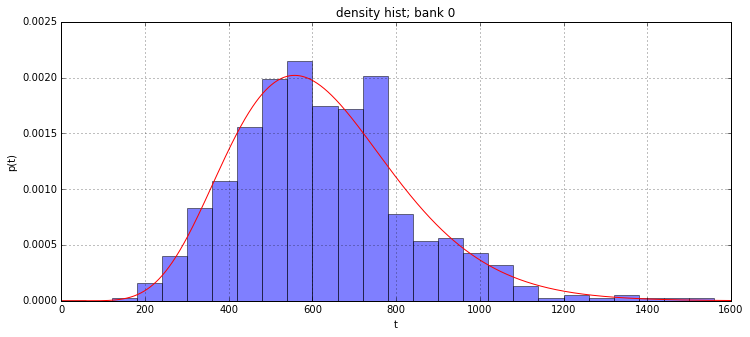

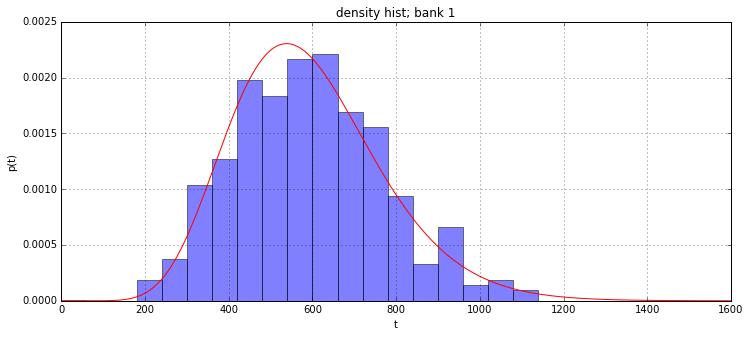

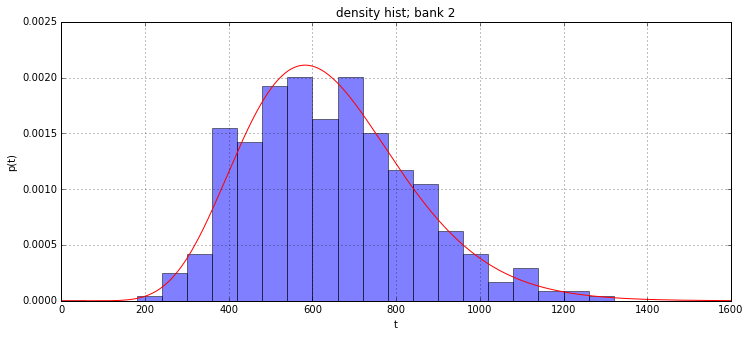

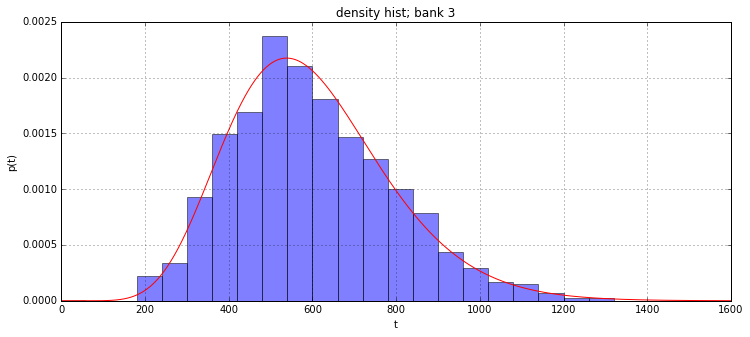

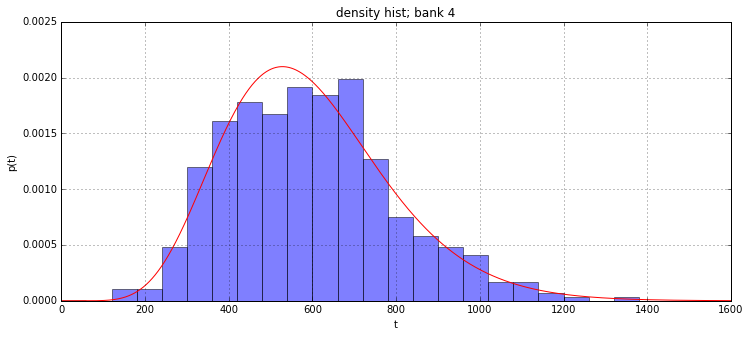

In [10]:
quanted_freq = []
R = [] #nbinom params
P = []
for info in data:
    r, p, q_fr = build_density_hist(info)
    quanted_freq.append(q_fr)
    R.append(r)
    P.append(p)
    

Применим критерий ХИ-квадрат:

In [15]:
def get_chisquare(idx) :
    quant = quanted_freq[idx]
    r = R[idx]
    p = P[idx]
    rv = sps.nbinom(r,p)
    
    n = np.sum(quant)
    OX = np.arange(0,1600,60)
    fexp = [n*(rv.cdf(OX[i]) - rv.cdf(OX[i-1])) for i in range(1,len(OX))]
    print('bank ' + str(idx) + ':')
    val , pval = sps.chisquare(quant, f_exp=fexp)
    print('statistic=' + str(val) +', pvalue=' + str(pval))
    
for i in range(5):
    get_chisquare(i)

bank 0:
statistic=30.6852559967, pvalue=0.19965323541
bank 1:
statistic=16.9449853306, pvalue=0.883779501908
bank 2:
statistic=14.7051593339, pvalue=0.948005496411
bank 3:
statistic=9.95773454388, pvalue=0.996764699988
bank 4:
statistic=17.6051332318, pvalue=0.858686735401


Критерий показал, что наше приближение очень хорошо работает (за исключением, быть может, первого банка) и можно считать, что время распределено по отрицательному биномиальному закону.

# 2

Построим доверительный интервал, уровня доверия $1 - \alpha$:

$P(N_t \leq z_{1 - \alpha}) \geq 1-\alpha$ , где $z_x$ - квантиль уровня $x$ для распределения $Poiss(\lambda t)$

$X_t \leq z_{1 - \alpha} - \frac{m(t-t_0)}{t_0}$

In [57]:
#count real number of waiting clients
def get_x_t(info) :
    OX = np.arange(np.max(info.end_time)+1)
    X_t = np.zeros(len(OX))
    cur_wait = 0
    id1 = 0
    id2 = 0
    start_time = np.sort(info.start_time)
    
    for t in OX:
        while id1 < len(info.arrival_time) and info.arrival_time[id1] <= t:
            cur_wait +=1
            id1 +=1
        while id2 < len(start_time) and start_time[id2] <= t:
            cur_wait -=1
            id2 +=1
        X_t[t] = cur_wait
        
#     plt.figure(figsize=(10,4))
#     plt.title('X_t, m = ' + str(info.num_operators))
#     plt.plot(OX,X_t)
#     plt.show()
#     print('maximum waiting clients = ' + str(np.max(X_t)))
    return X_t

X_t = []
for info in data:
    X_t.append(get_x_t(info))
    

In [135]:
def get_poiss_confidence_interval(lmb , alpha):
    return 0 , sps.poisson.ppf(1-alpha,lmb)

def build_confidence_interval(m , t0, lmb, alpha,T_max,X_t):
    L = []
    R = []
    M = []
    OX = np.arange(0,T_max + 1)
    for t in OX:
        l_n,r_n = get_poiss_confidence_interval(lmb=t*lmb,alpha=alpha)
        M.append(l_n)
        L.append(max(l_n - m*t/t0,0))
        R.append(max(r_n - m*(t-t0)/t0,0))
        
    plt.figure(figsize=(15,7))
    plt.grid(True)
    plt.plot(OX,L,'r')
    plt.plot(OX,R,'b')
    plt.plot(OX,X_t,'--',color='black')
    plt.fill_between(OX,L,R,alpha=0.3,color='g')
#     plt.plot(OX,M)
#     plt.xlim(500,2000)
#     plt.ylim(0,20)
    
    plt.title('lambda=' + str(lmb) + ' ; m=' + str(m))
    plt.show()
    return R


maximum waiting clients = 12.0


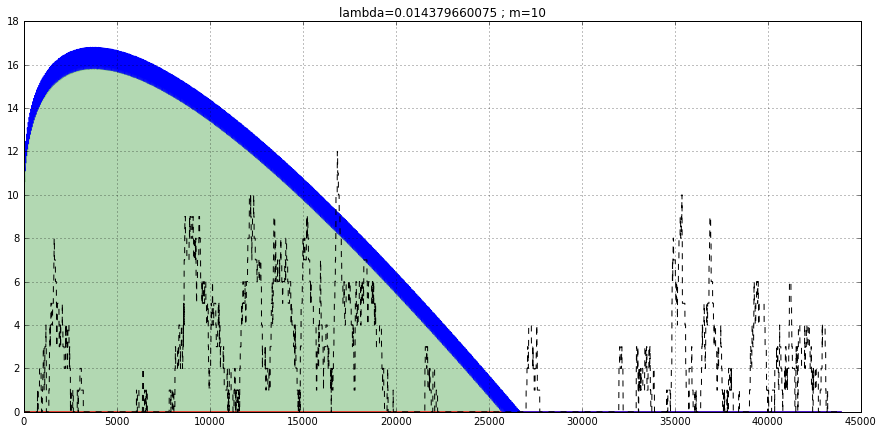

maximum waiting clients = 10.0


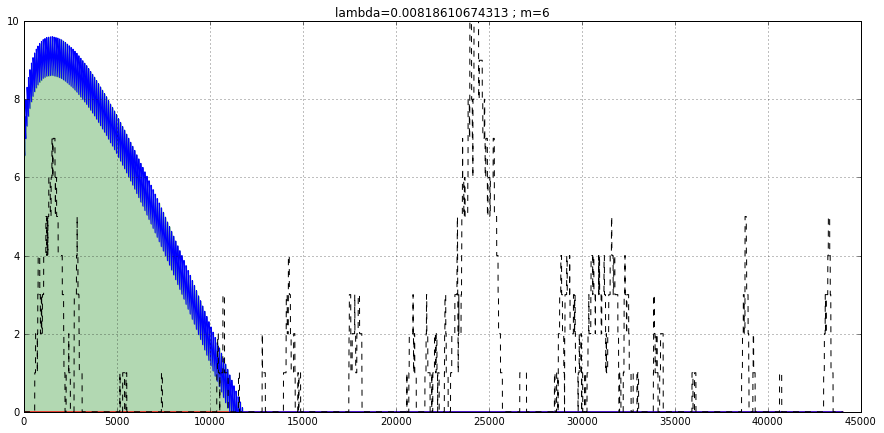

maximum waiting clients = 6.0


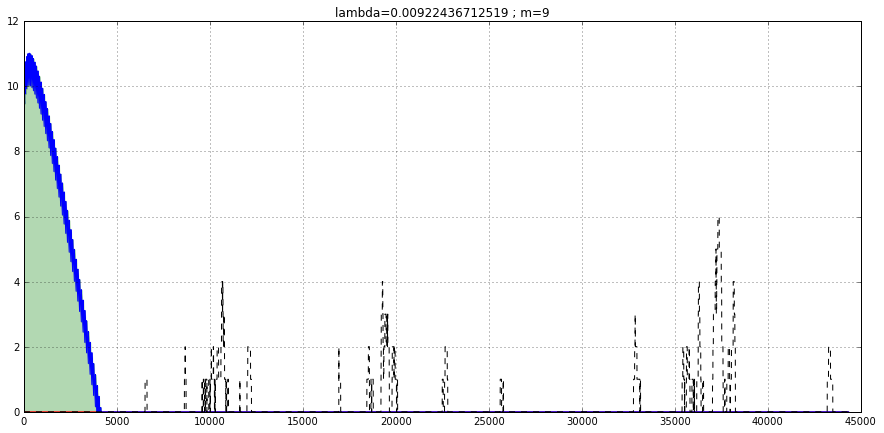

maximum waiting clients = 9.0


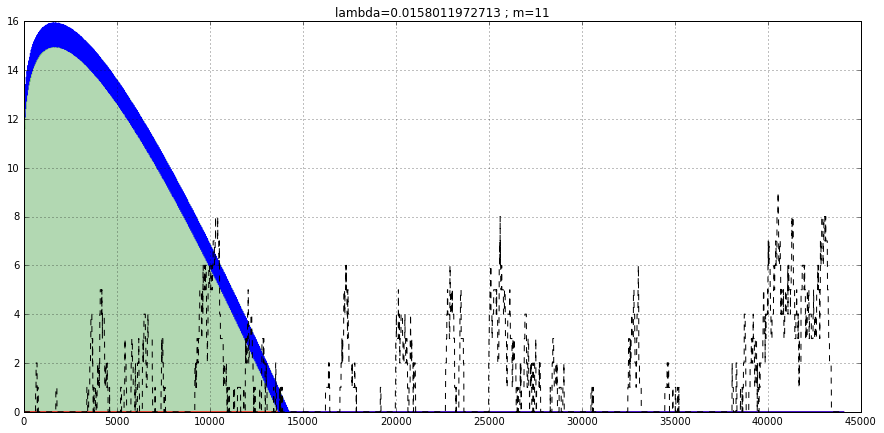

maximum waiting clients = 11.0


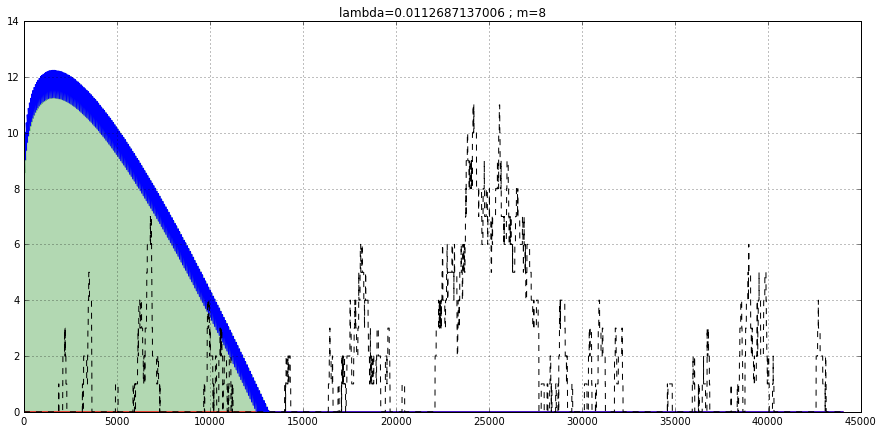

In [70]:
for i in range(5): #len(data)
    print('maximum waiting clients = ' + str(np.max(X_t)))
    build_confidence_interval(m=data[i].num_operators,
                             t0=avg_service_duration[i],
                             lmb=lmb[i],
                             alpha=0.05,
                             T_max = np.max(data[i].end_time),
                             X_t=X_t[i])

Видим, что при данных $m$ для каждого банка верхняя граница доверительного интервала перестает возрастать с ростом времени и обращается в $0$. Это происходит из-за предположения(используемого в формуле для интервала), что в любой момент времени все операторы заняты работой. Но как видно на графиках из пункта 1, большую часть времени работает меньшее число операторов(т.к. каждый вновь пришедший клиент почти всегда мгновенно получает оператора).

Оценим интервал другим способов, взяв за $m$ не количество операторов в банке, а среднее количество операторов единовременно обслуживающих клиентов.

m = 10 ; m_avg = 8.83709181932, m_max = 10.0
ratio of max workload =  0.612470133121


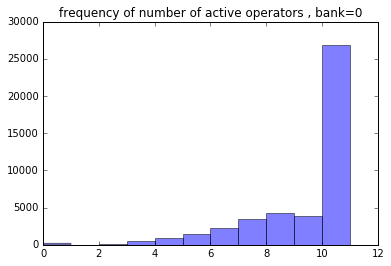

m = 6 ; m_avg = 4.76808331628, m_max = 6.0
ratio of max workload =  0.496782408987


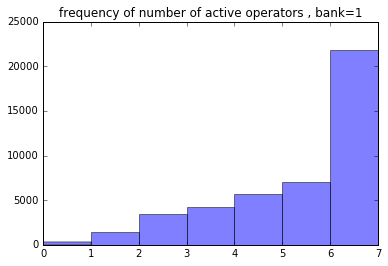

m = 9 ; m_avg = 5.77938920967, m_max = 9.0
ratio of max workload =  0.197762540599


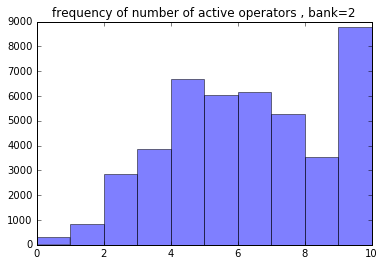

m = 11 ; m_avg = 9.30182250577, m_max = 11.0
ratio of max workload =  0.522192495026


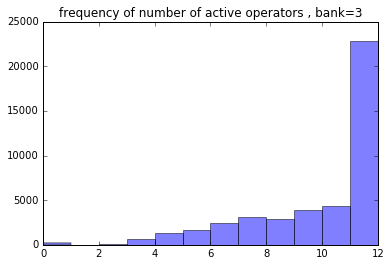

m = 8 ; m_avg = 6.61844036697, m_max = 8.0
ratio of max workload =  0.510183486239


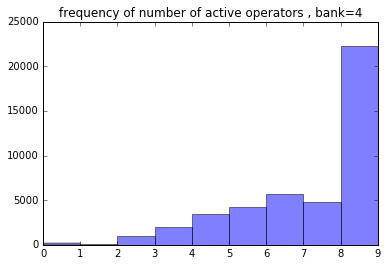

In [116]:
def get_m_avg(info):
    OX = np.arange(0,info.end_time[-1]+1,1)
    qnt = np.zeros(len(OX))
    cur_m = 0
    id1 = 0
    id2 = 0
    start_time = np.sort(info.start_time)
    end_time = np.sort(info.end_time)
    
    for t in OX:
        while id1 < len(start_time) and start_time[id1] <= t:
            cur_m +=1
            id1 +=1
        while id2 < len(end_time) and end_time[id2] <= t:
            cur_m -=1
            id2 +=1
        qnt[t] = cur_m
        
    m_avg = np.mean(qnt)
    print('m = ' + str(info.num_operators) +
          ' ; m_avg = ' + str(m_avg) + ', m_max = ' + str(np.max(qnt)))
    
    counter = list(Counter(qnt).values())
    print('ratio of max workload = ', counter[-1]/np.sum(counter))
    
#     plt.figure(figsize=(5,3))
#     plt.title('num of active operators')
#     plt.bar(OX,qnt,1)
#     plt.show()
    plt.figure()
    plt.title('frequency of number of active operators , bank=' + str(info.id))
    plt.hist(qnt,bins=np.arange(info.num_operators + 2),normed=False,facecolor='b', alpha=0.5)

    plt.show()
    return m_avg
    

m_avg = []
for info in data:
    m_avg.append(get_m_avg(info))


Мы построили диаграммы распределения времени по количеству активных операторов. 
У банка под номером 2 дела идут очень хорошо и лишь около $20 \%$ времени работают все операторы.

maximum waiting clients = 12.0


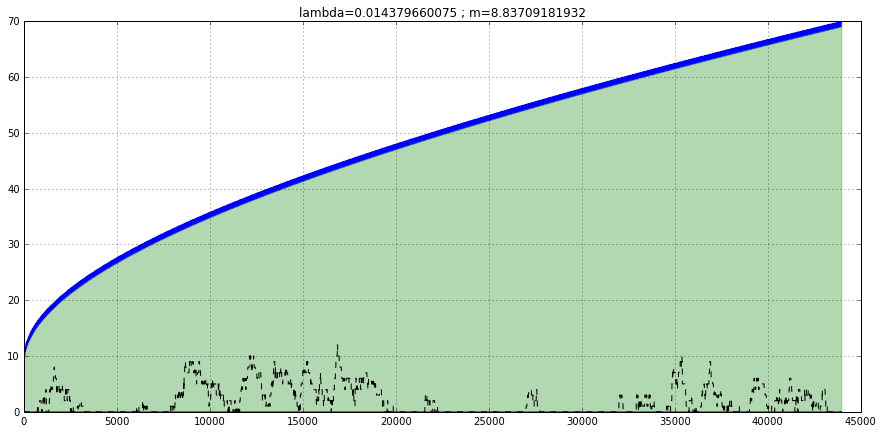

maximum waiting clients = 10.0


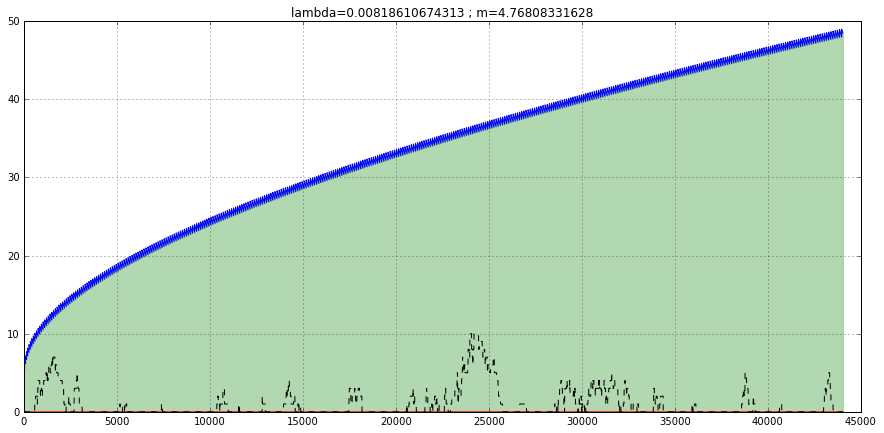

maximum waiting clients = 6.0


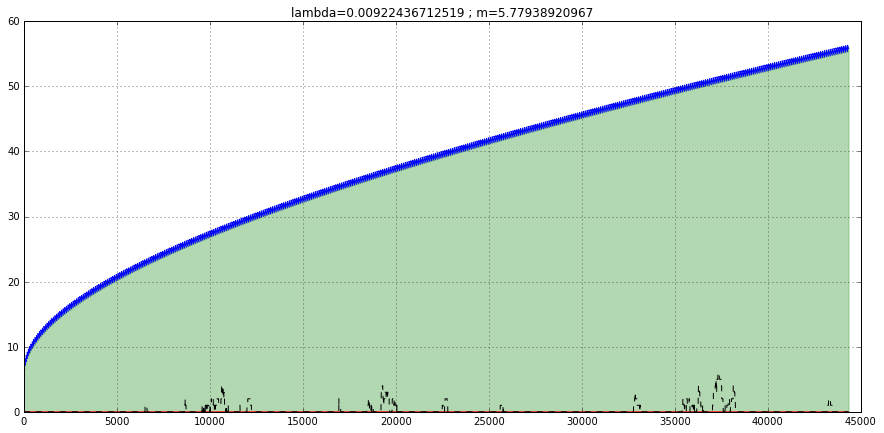

maximum waiting clients = 9.0


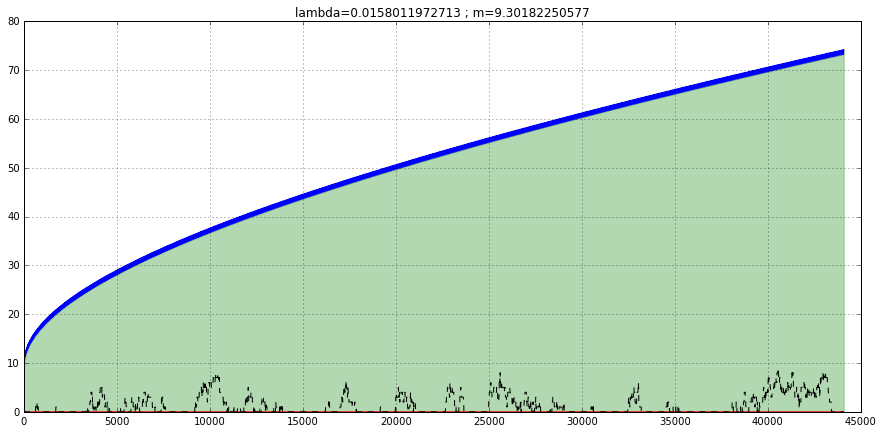

maximum waiting clients = 11.0


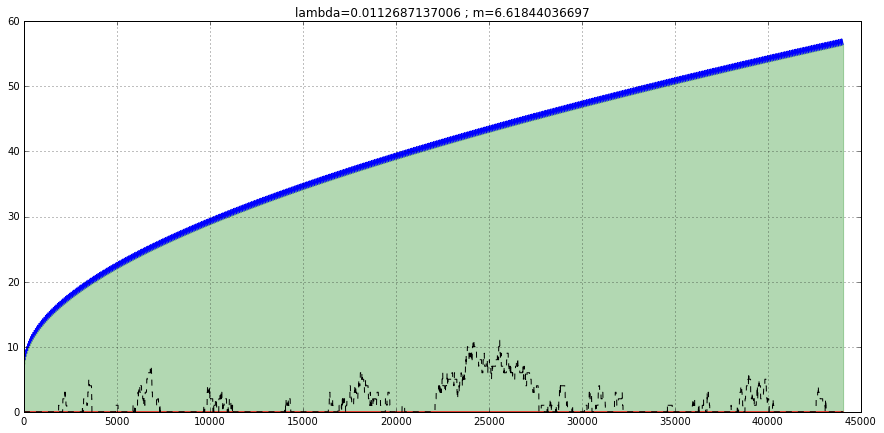

In [68]:
for i in range(5): #len(data)
    build_confidence_interval(m=m_avg[i],
                             t0=avg_service_duration[i],
                             lmb=lmb[i],
                             alpha=0.05,
                             T_max = np.max(data[i].end_time),
                             X_t=X_t[i])
    

Теперь видим, что реальные значения количества ожидающих клиентов попадают в доверительный интервал.

# 3

Очередь образуется и растет, если средняя скорость прихода клиентов меньше среднего времени обслуживания.

Т.е. очередь образуется, если $E\Delta t = \frac{1}{\lambda} > \frac{\overline{service\_duration}}{m}$

In [132]:
def get_best_operators_qnt(i):
    m = data[i].num_operators
    a = avg_service_duration[i]
    m_best = int(np.ceil(a * lmb[i]))
    print('     ' + str(m_best) + ' : ' + str(m))
    return m_best
    
m_best = []
print('m_best : m')
for i in range(5):
    m_best.append(get_best_operators_qnt(i))

m_best : m
     9 : 10
     5 : 6
     6 : 9
     10 : 11
     7 : 8


Для каждого банка можно уволить от одного или трех операторов (для каждого отделения на величину $m^i - m^i_{best}$).

Найдем количество стульев для каждого отделения, считая, что мы уже перераспределили сотрудников оптимальным образом.

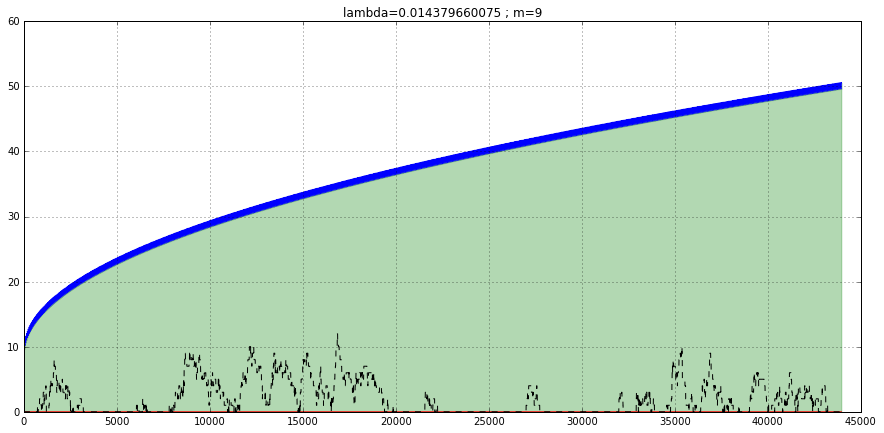

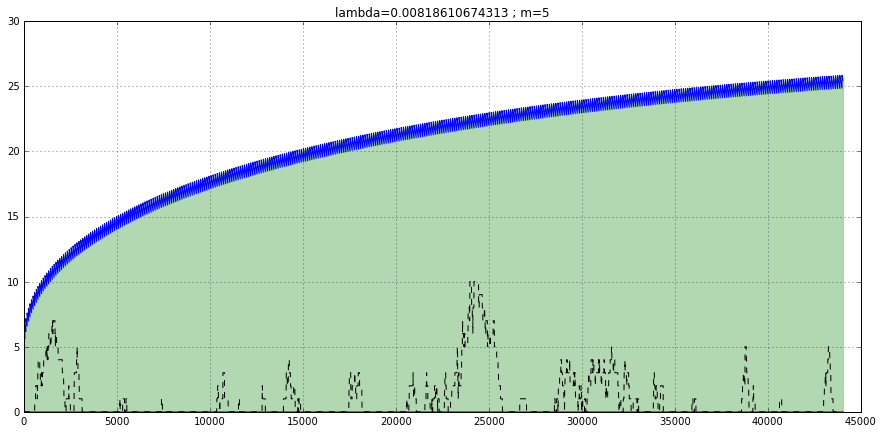

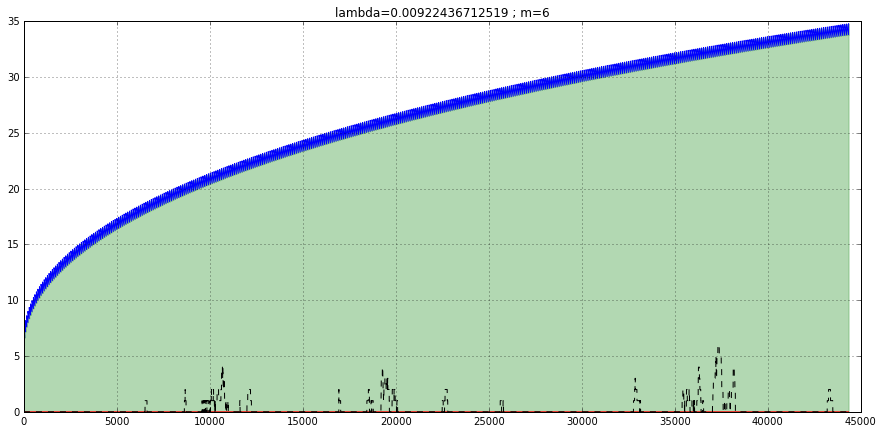

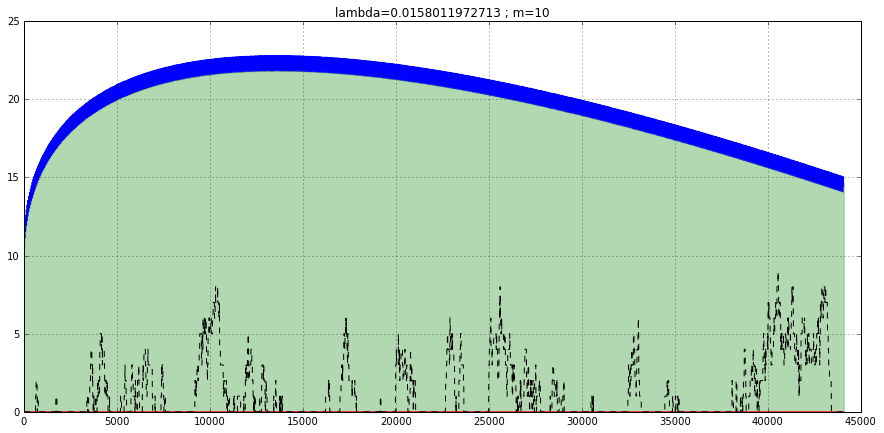

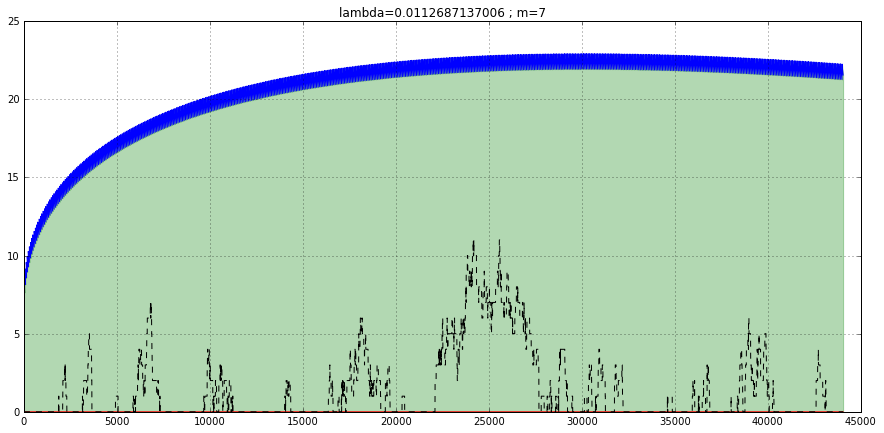

In [137]:
chair = []
for i in range(5): #len(data)
    chair.append(np.max(build_confidence_interval(m=m_best[i],
                             t0=avg_service_duration[i],
                             lmb=lmb[i],
                             alpha=0.05,
                             T_max = np.max(data[i].end_time),
                             X_t=X_t[i])))
    

In [140]:
for c in chair:
    print(int(c))

50
25
34
22
22


Поставив такое количество стульев в каждое отделение, с вероятностью $p > 1 - \alpha = 95\%$ каждый ожидающий клиент не будет стоять.

# 4

Получим среднее время $V_t$ ожидания следующего клиента, при условии что во момент времени t вышел клиент:


In [147]:
def get_avg_next_client_time(info):
    arrival_id = 0
    arrival_t = np.sort(info.arrival_time)
    end_t = np.sort(info.end_time)
    res = []
    for t in end_t:
        while arrival_id < len(arrival_t) and arrival_t[arrival_id] < t:
            arrival_id += 1
        if arrival_id < len(arrival_t):
            res.append(arrival_t[arrival_id] - t)
    return np.mean(res)
    
next_arrived = []
for i in range(5):
    info = data[i]
    next_arrived.append(get_avg_next_client_time(info))
    print('next avg = ' + str(next_arrived[-1]) + '; 1/lmb = ' + str(1/lmb[i]))


next avg = 65.1032786885; 1/lmb = 69.5426731079
next avg = 154.160349854; 1/lmb = 122.15819209
next avg = 107.384020619; 1/lmb = 108.408521303
next avg = 63.4274924471; 1/lmb = 63.2863436123
next avg = 92.6541666667; 1/lmb = 88.7412731006


Полученные значения почти совпадают со средним временем ожидания каждого следующего клиента $1/\lambda$. Так получилось из-за того, что величина $V_t = S_{N_t + 1} - t$ - 'перескок' из теоретической задачи 2.3, где было доказано, что $V_t \sim Exp(\lambda)$  (для $\xi_i \sim Exp(\lambda)$)


Через 10 минут клиент так и не пришел. Сколько еще ждать?

Ответ: Его ждать  $V_t \sim Exp(\lambda)$, так как 'перескок' не зависит от 'недоскока': $U_t = t - S_{N_t}$
 ( в нашем случае $U_t$ = 10 минут).
 


# 5

Посчитаем средний коэффициент наклона для $S_n = \xi_1 + \xi_2 + \dots + \xi_n$, отдельно для  каждого префикса и суффикса (превосходящих некоторую длину), и найдем максимальную разность этих коэффициентов, в этой точке и будем предпологать возможное наличие излома.

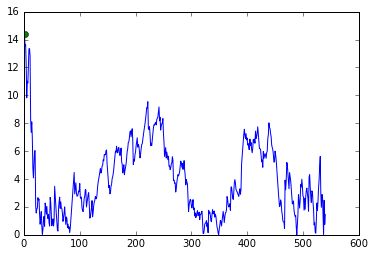

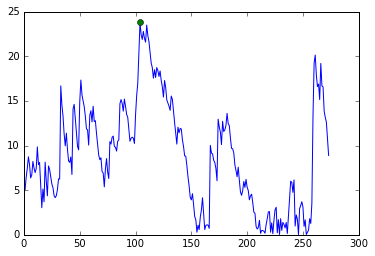

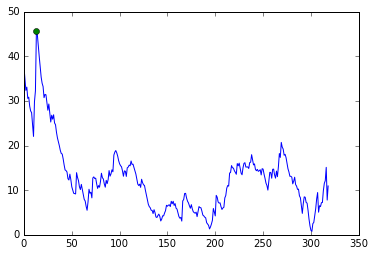

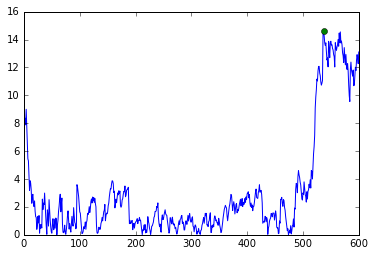

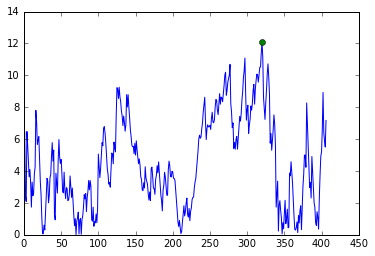

In [255]:
def get_ksi(info):
    ksi = np.zeros(len(info.arrival_time))
    last = 0
    for i in range(len(info.arrival_time)):
        ksi[i] = info.arrival_time[i] - last
        last = info.arrival_time[i]
    return ksi

l_bound = 40
def get_the_rift(ksi) :
    l = l_bound
    r = len(ksi) - l_bound
    pref = np.sum(ksi[0:l])
    suf = np.sum(ksi[l:])
    diff = []
    for mid in range(l,r):
        pref += ksi[mid]
        suf -= ksi[mid]
        lp = pref/(mid + 1)
        rp = suf / (len(ksi) - mid - 1)
        diff.append(abs(lp - rp)) 
    return diff

ksi = []
rift_pos = []
diff = []
for i in range(5):
    ksi.append(get_ksi(data[i]))
    diff.append(get_the_rift(ksi[i]))
    rift_pos.append(np.argmax(diff[i]) + l_bound)
    plt.plot(np.arange(len(diff[i])),diff[i])
    plt.plot([rift_pos[i]-l_bound] , [diff[i][rift_pos[i] - l_bound]], 'o')

    plt.show()

In [256]:
print('probably rift positions:')
print(rift_pos)
print('coefficiens ratio (k_1 / k_2) :')
for i in range(5):
    a = np.mean(ksi[i][:rift_pos[i]])
    b = np.mean(ksi[i][rift_pos[i]:])
    print(max(a,b)/min(a,b))

probably rift positions:
[41, 144, 53, 577, 360]
coefficiens ratio (k_1 / k_2) :
1.23114550401
1.17956212267
1.30953807416
1.28295138598
1.13338082278


Как видно, существеннее всего отличаются параметры интенсивности для банков с номерами 2 и 3, что и видно на графиках(около $29-30\%$). Для остальных же коэффициенты отличаются на не более чем $23%$ и эти процессы можно приближенно считать однородными.




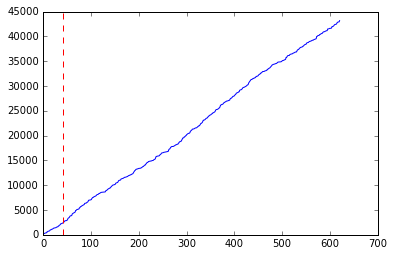

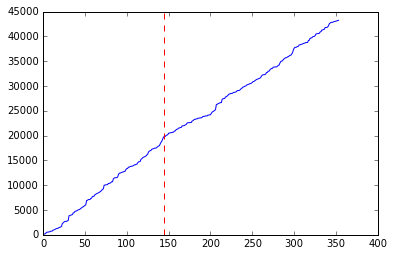

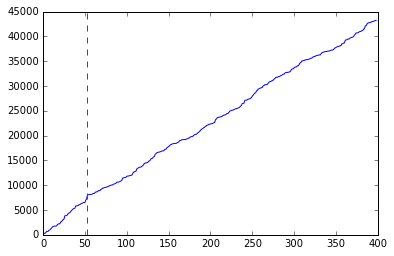

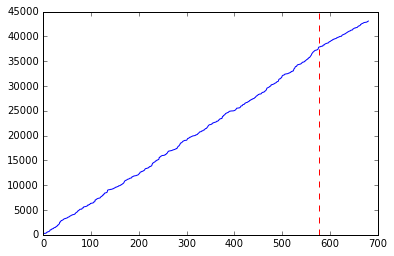

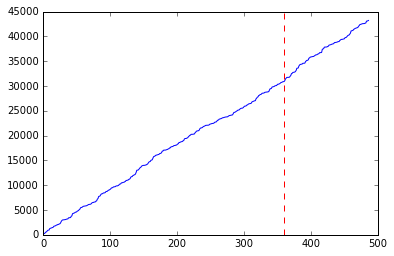

In [257]:

def build_S_n_plot(ksi,rift):
    S = [np.sum(ksi[:i]) for i in range(1,len(ksi) + 1)]
    plt.plot(np.arange(len(ksi)), S)
    plt.plot([rift,rift],[0,45000],'--',color='r')
    plt.show()


for i in range(5):
    build_S_n_plot(ksi[i],rift_pos[i])


Коэффициенты наклона отличаются сильно, почти в половину от среднего коэффициента всей прямой целиком. Можно считать, что процесс до и после этого момента имел разную интенсивность.

# 6

Проверка автоматическая, лучше не читать что там.

In [218]:
pref_f_name = 'data_t5/process_'
def read_from_file(i):
    fpath = pref_f_name + str(i)
    res = []
    with open(fpath) as f_in:
        for line in f_in:
            res.append(float(line))
    return res

ksi_values = []
for i in range(5):
    ksi_values.append(read_from_file(i))
ksil = []
ksir = []

In [231]:
def calc_diff(vals,need_new):
    if need_new:
        ksil.clear()
        ksir.clear()
    id = 0
    for ksi in vals:
        print(1/np.mean(ksi))
        if len(ksi) < 41:
            continue
        diff = get_the_rift(ksi)
        rift_pos = np.argmax(diff) + l_bound
        plt.plot(np.arange(len(diff)),diff)
        plt.plot([rift_pos-l_bound] , [diff[rift_pos - l_bound]], 'o')

        plt.show()
        if need_new:
            ksil.append(ksi[:rift_pos])
            ksir.append(ksi[rift_pos:])
        OX = np.arange(len(ksi) + 1)
        OY = [0]
        for x in ksi:
            OY.append(OY[-1] + x)
        plt.plot(OX,OY)
        plt.plot([rift_pos,rift_pos],[0,np.max(OY)])
        a = 1/np.mean(ksi[:rift_pos + 1])
        b = 1/np.mean(ksi[rift_pos+1:])
        print('id = ' + str(id))
        print(a)
        print(b)
        print(max(a,b)/min(a,b))
        print(rift_pos)
        plt.show()
        id+=1

0.180152069641


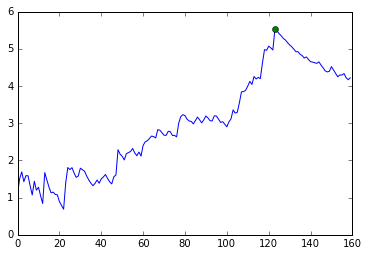

id = 0
0.140790154413
0.640919928855
4.55230645585
143


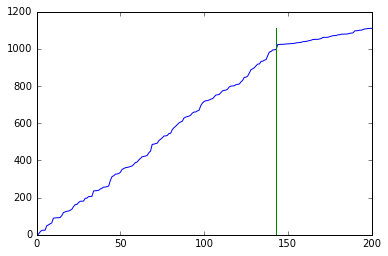

0.662245992768


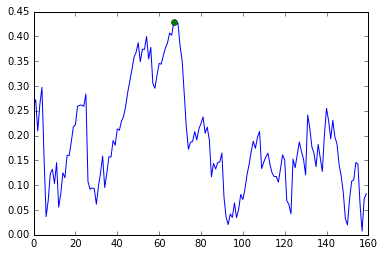

id = 1
0.78747671626
0.58868903423
1.33767858831
87


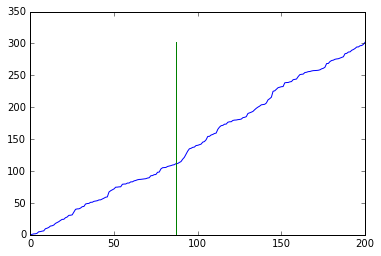

0.510463123567


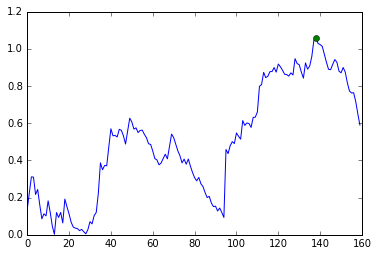

id = 2
0.45959270837
0.894364969743
1.94599468933
158


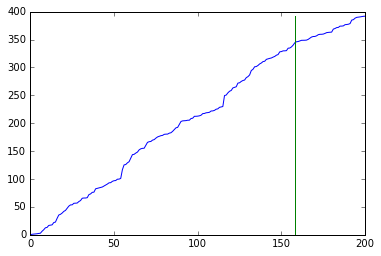

0.388181886846


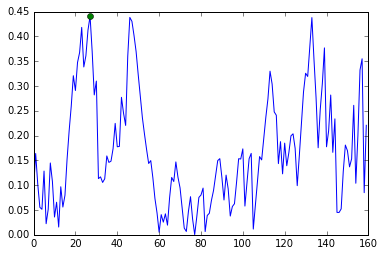

id = 3
0.446218461962
0.372867269408
1.19672199352
47


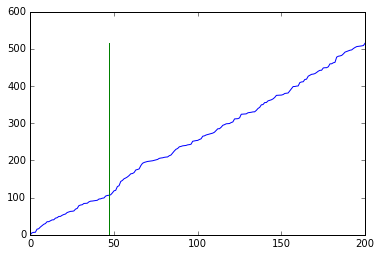

0.609016385702


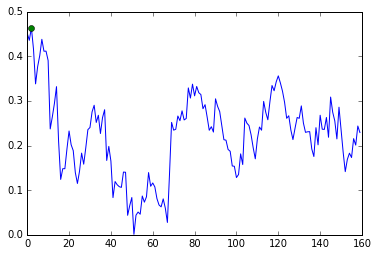

id = 4
0.811951416499
0.589859277076
1.37651715935
22


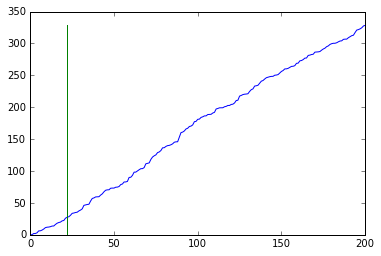

In [232]:
calc_diff(ksi_values,True)

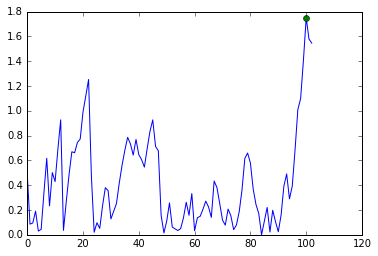

id = 0
0.149309941131
0.118373197937
1.26134922206
120


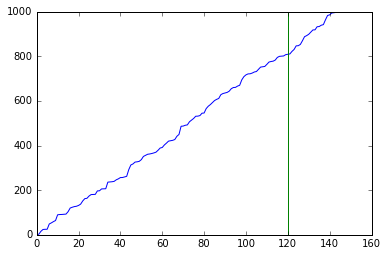

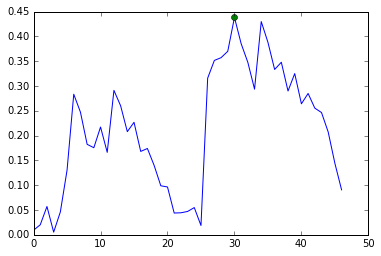

id = 1
0.683050753295
0.974826244127
1.42716516954
50


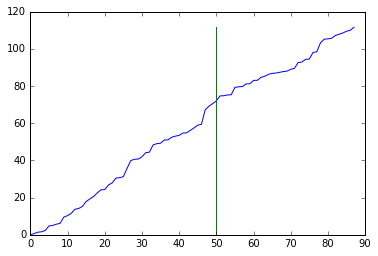

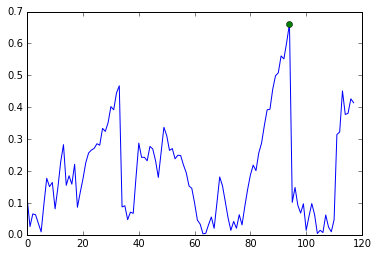

id = 2
0.500335497793
0.375934610598
1.33091097145
114


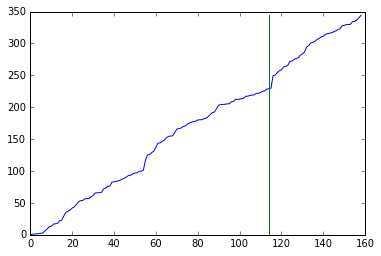

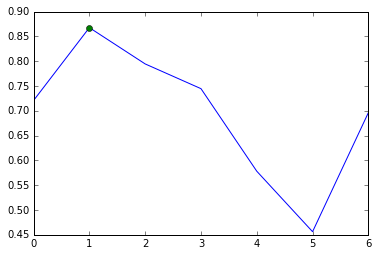

id = 3
0.367379726837
0.539276862688
1.46790044005
21


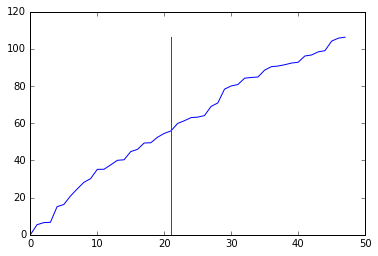

In [229]:
# print(ksil)
calc_diff(ksil,False)

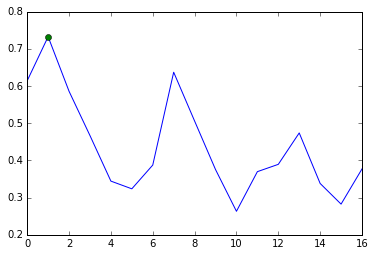

id = 0
0.408412153491
0.582766437568
1.42690767791
21


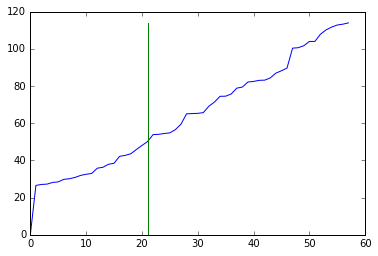

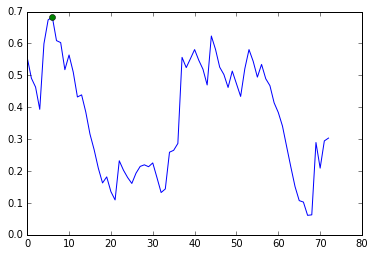

id = 1
0.453524333057
0.657119781388
1.44891846697
26


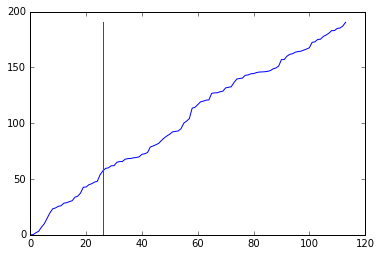

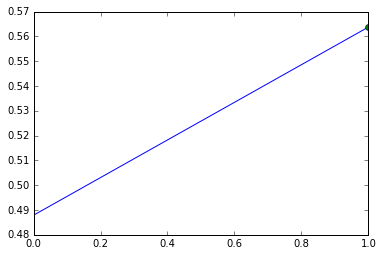

id = 2
1.15706900977
0.700276524844
1.65230300991
21


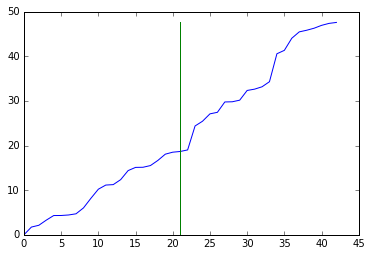

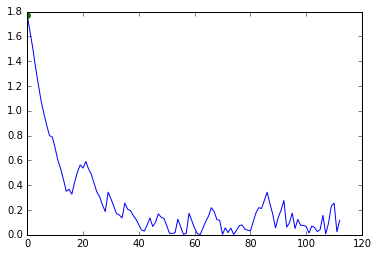

id = 3
0.237962580701
0.411559455973
1.72951333256
20


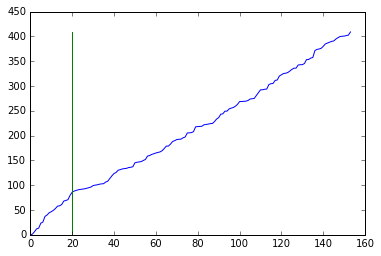

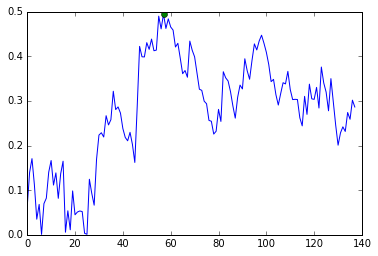

id = 4
0.508214376805
0.678766370928
1.33559065211
77


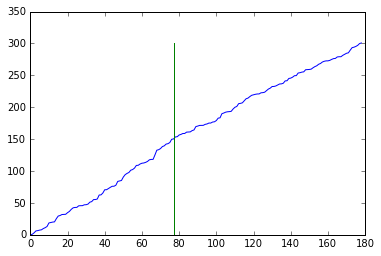

In [230]:
calc_diff(ksir,False)